In [1]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
trans = transforms.Compose([transforms.ToTensor()
                           ])

train_data = torchvision.datasets.ImageFolder(root='/home/hyeonwoo/MRI.data/train', transform=trans)

val_data = torchvision.datasets.ImageFolder(root='/home/hyeonwoo/MRI.data/val', transform=trans)

In [4]:
batch_size = 50

train_loader = DataLoader(dataset = train_data,batch_size = batch_size, shuffle = True, num_workers=0)

val_loader = DataLoader(dataset = val_data,batch_size = batch_size, shuffle = True, num_workers=0)


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(16*53*53, 120),
            nn.ReLU(),
            nn.Linear(120, 2)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)
        out = self.layer3(out)
        return out

In [6]:
net = CNN().to(device)

In [7]:
print(net)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=44944, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=2, bias=True)
  )
)


In [8]:
optimizer=optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss().to(device)

In [9]:
total_batch = len(train_loader)
num_epochs = 6

train_loss_list=[]
val_loss_list = []
train_acc_list=[]
val_acc_list=[]
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader):
        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = net(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = torch.argmax(out, 1) == labels
        train_acc += pred.sum()
        
    
        if (i+1) % 100 ==0:
            with torch.no_grad():
                val_loss=0.0
                val_acc = 0.0
                for j, val_data in enumerate(val_loader):
                    imgs,label = val_data
                    imgs = imgs.to(device)
                    label = label.to(device)
                    val_out = net(imgs)
                    v_loss = criterion(val_out, label)
                    val_loss += v_loss
                    val_pred = torch.argmax(val_out, 1) == label
                    val_acc += val_pred.sum()
                    
            print("epoch: {}/{}, step: {}/{}, train loss: {:.4f}, val loss: {:.4f}, train acc: {:.2f}, val acc: {:.2f}".format(
                epoch+1, num_epochs, i+1, total_batch, train_loss/100, val_loss/len(val_loader), train_acc/100/batch_size, val_acc/len(val_loader.dataset)
            ))
            
            train_loss_list.append(train_loss/100)
            val_loss_list.append(val_loss/len(val_loader))
            train_acc_list.append(train_acc/100/batch_size)
            val_acc_list.append(val_acc/len(val_loader.dataset))
            train_loss = 0.0
            train_acc = 0.0

epoch: 1/6, step: 100/180, train loss: 0.5675, val loss: 0.5309, train acc: 0.74, val acc: 0.78
epoch: 2/6, step: 100/180, train loss: 0.4270, val loss: 0.4860, train acc: 0.81, val acc: 0.77
epoch: 3/6, step: 100/180, train loss: 0.3766, val loss: 0.5314, train acc: 0.83, val acc: 0.74
epoch: 4/6, step: 100/180, train loss: 0.3467, val loss: 0.4111, train acc: 0.85, val acc: 0.80
epoch: 5/6, step: 100/180, train loss: 0.2663, val loss: 0.3691, train acc: 0.89, val acc: 0.82
epoch: 6/6, step: 100/180, train loss: 0.2248, val loss: 0.2915, train acc: 0.92, val acc: 0.87


Text(0, 0.5, 'loss')

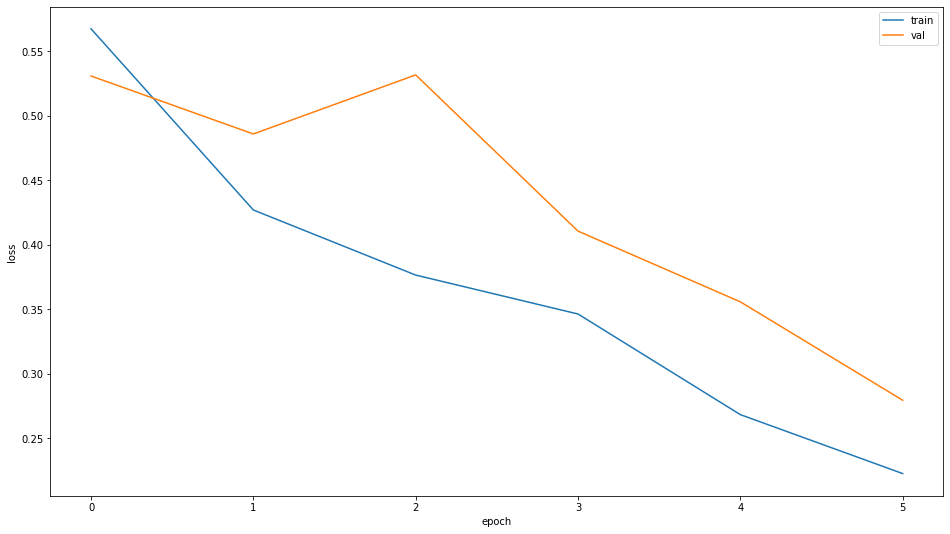

In [13]:
plt.figure(figsize = (16, 9))
x_range = range(len(train_loss_list))
plt.plot(x_range, train_loss_list, label="train")
plt.plot(x_range, val_loss_list, label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

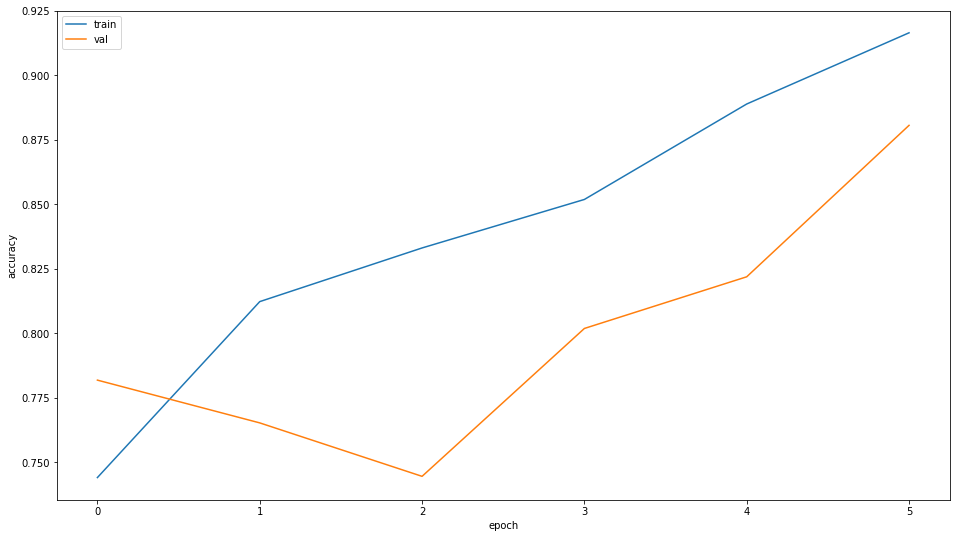

In [14]:
plt.figure(figsize = (16, 9))
x_range = range(len(train_loss_list))
plt.plot(x_range, train_acc_list, label="train")
plt.plot(x_range, val_acc_list, label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [15]:
#val acc
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for num, data in enumerate(val_loader):
        imgs, label = data
        imgs = imgs.to(device)
        label = label.to(device)
        
        prediction = net(imgs)
        model_label = prediction.argmax(dim=1)
        
        corr  = label[label == model_label].size(0)
        corr_num += corr 
        total_num += label.size(0)
        
print('Accuracy:{:.2f}'.format(corr_num/total_num*100))

Accuracy:88.67


In [16]:
test_data = torchvision.datasets.ImageFolder(root = '/home/hyeonwoo/MRI.data/test',transform = trans)

test_set = DataLoader(dataset = test_data, batch_size = len(test_data))

In [17]:
#test
with torch.no_grad():
    for num, data in enumerate(test_set):
        imgs, label = data
        imgs = imgs.to(device)
        label = label.to(device)
        
        prediction = net(imgs)
        
        correct_prediction = torch.argmax(prediction, 1) == label
        
        accuracy = correct_prediction.float().mean()
        print('Accuracy:{:.2f} %'.format(100*accuracy.item()))

Accuracy:93.57 %


In [19]:
#confusion matrix
nb_classes = 2
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for num, data in enumerate(test_set):
        imgs, label = data
        imgs = imgs.to(device)
        label = label.to(device)
        
        prediction = net(imgs)
        
        _ , preds = torch.max(prediction, 1)
        for t, p in zip(label.view(-1), preds.view(-1)):
            
            confusion_matrix[t.long(), p.long()] += 1
            
print(confusion_matrix)
        

tensor([[1127.,   68.],
        [  83., 1180.]])


In [20]:
print(preds)
print(label.shape)
print(preds.view(-1))

tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')
torch.Size([2458])
tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')


In [21]:
print(len(test_data))

2458


In [22]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9431, 0.9343])
